# Continuous Control with a Deep Deterministic Policy Gradient (DDPG)

---

I wanted to do this whole thing on my own computer.  However, I'm still struggling to get the Unity ML-Agents environments to work properly.  Because I'm on a time schedule, I need to bang out the project.  So I'm using the Udacity Workspace to do this project.  It sucks, but I'm working to resolve all of this.  

### 1. Start the Environment

We need to install a bunch of packages.  Run the next two code cells to do the install.  This line will take a few minutes to run and will only work in the Udacity Workspace.

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
import random
import time
import torch
import workspace_utils
from ddpg_agent import Agent
from collections import deque
from unityagents import UnityEnvironment
from workspace_utils import active_session
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we need to install the environment.  Because I am in the Udacity Workspace, the environment already exists.  All I need to do it tap into it via the proper file path.  

In [3]:
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

We have a double-jointed arm that is trying to move, and stay, in a target location.  The target location is a "bubble area" that moves over time. If the double-jointed arm can keep its end in the "bubble area", it receives a Reward of plus 0.1 for every time period it is there.  If the double-jointed arm has its end outside of the "bubble area", it receives a Reward of minus 0.1.

The goal here is for the double-jointed arm to stay in the "bubble-area" for as long as possible.
So there are thirty-three different things we can keep track of when the double-jointed arm is running.  These things consist of the position of the double-jointed arm, the rotation of the double-jointed arm, the velocity of the double-jointed arm, and the angular velocities of the double-jointed arm.

The Agent runing the double-jointed arm has Actions that it can take in order to keep the tip of the arm in the "bubble area".  The Agent can control the clock-wise torque of each joint (denoted as a positive number), and the counter-clock-wise torque of each joint (denoted as a negative number).  There are two degrees of freedom for each joint.  That makes a total of four Actions, which all get clumped together into a single vector.  The value of these Actions can range anywhere from negative one to positive one.

The code below will print out some key information about the environment that this double-jointed arm resides in.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you can see how to use the Python API to control the agent and receive feedback from the environment.

Because I'm in the Udacity Workspace, you will not be able to watch the Agents while they are training.  Suck ... I know.

This code takes random Actions, so it's performance will be less than stellar.  However, it should prove that everything is set up properly and working as expected.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.22549999495968223


### 4. Now to train the Agent

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- **_After training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

We start with the Deep Deterministic Policy Gradient (DDPG) function.

In [7]:
def ddpg(n_episodes=1000, max_t=1000, train_mode=True):
    
    '''
    Deep Deterministic Policy Gradient (DDPG)
    
    parameters:
    
    n_episodes            ; the number of training episodes
    mat_t                 ; the number of time-steps for each episode
    train_mode            ; set the environment into "Train Mode" if TRUE
    '''
    
    scored = []
    mov_avg = []                                                    # list containing the moving averages
    mean_scores = []
    mean_score = 0.0
    solved = False
    scores_window = deque(maxlen=100)                               # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]     # reset the environment    
        states = env_info.vector_observations                       # get the current state (for each agent)
        scores = np.zeros(num_agents)                               # initialize the score (for each agent)
        #state = env.reset()
        agent.reset()
        #score = 0
        
        if train_mode:
            for t in range(max_t):
                actions = agent.act(states, add_noise=True)         # select a new action (for each agent)
                #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
                env_info = env.step(actions)[brain_name]            # send all actions to tne environment
                next_states = env_info.vector_observations          # get next new state (for each agent)
                rewards = env_info.rewards                          # get new reward (for each agent)
                dones = env_info.local_done                         # see if episode finished
                # Set up a replay buffer and save what happened and perform a leanring step
                for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done) # this is the learning step
                scores += rewards                                   # update the new score (for each agent)
                states = next_states                                # roll over states to next time step
                if np.any(dones):                                   # exit loop if episode finished
                    break
            
            scores_window.append(scores)                            # save the most recent new score
            if solved==False:
                scored.append(scores)                               # save the most recent new score to the total
            average = np.mean(scores_window)                        # calculate the average
            if solved==False:
                mov_avg.append(average)                             # save the most recent moving average
                
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            
            if i_episode % 10 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if (np.mean(scores_window) >= 30.0) & (solved==False):
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode, np.mean(scores_window)))
                solved = True
            if (np.mean(scores_window) >= 32.0) & (solved==True):
                print('\nEnvironment solved with BUFFER in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode, np.mean(scores_window)))  # to ensure that my final plot stays > 30
        
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')   # save the actor weights
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save the critic weights
                break
                
        if not train_mode:
            while True:
                actions = agent.act(states, add_noise=True)        # select a new action (for each agent)
                #actions = np.clip(actions, -1, 1)                 # all actions between -1 and 1
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next new state (for each agent)
                rewards = env_info.rewards                         # get new reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                agent.step(state, action, reward, next_state, done)# this is the learning step
                scores += rewards                                  # update the new score (for each agent)
                states = next_states                               # roll over states to next time step
                if np.any(n_done):                                 # exit loop if episode finished
                    scored.append(scores)
                    mean_score = np.mean(scores)
                    mean_scores.append(mean_score)
                    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
                    break
                
    return scored, mov_avg, mean_scores

Now we grab the Agent and run the ddpg function and see how well we learn ...

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
with active_session():
    scored, mov_avg, _ = ddpg()

Episode 10	Average Score: 4.72
Episode 20	Average Score: 9.52
Episode 30	Average Score: 16.38
Episode 40	Average Score: 20.17
Episode 50	Average Score: 22.59
Episode 60	Average Score: 24.50
Episode 70	Average Score: 26.01
Episode 80	Average Score: 26.97
Episode 90	Average Score: 27.81
Episode 100	Average Score: 28.14
Episode 108	Average Score: 30.23
Environment solved in 108 episodes!	Average Score: 30.23
Episode 110	Average Score: 30.64
Episode 116	Average Score: 32.05
Environment solved with BUFFER in 116 episodes!	Average Score: 32.05


### 4. Now Let's Plot Our Results From Training

There are two lines in the plot below.  The Blue line shows what the scores where during training.  The Yellow line shows the average score over 100 episodes.

We are considered "trained" when we can average a score of 30 for every Agent over 100 episodes.  And that happened at episode 108.

I went ahead and ran the training a little bit longer in an attempt to ensure that my saved weights will give me a good chance of getting a score of 30 or better.  Once the score average hit 32, I saved the weights.

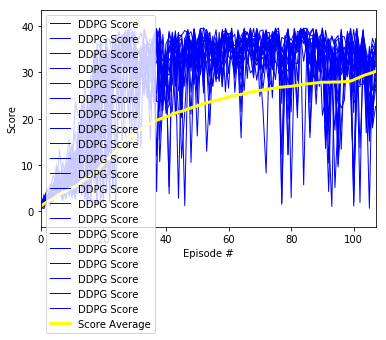

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scored)), scored, c='blue', linewidth=1, label="DDPG Score")
plt.plot(np.arange(len(scored)), mov_avg, c='yellow', linewidth=3, label="Score Average")
plt.legend(loc='upper left')
plt.margins(x=0.0, y=0.1)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Now that we are finished, we can close the environment.

In [10]:
env.close()